In [20]:
import numpy as np
import copy
import pickle
import pandas as pd 
import time
import os
import random
import argparse
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
    
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
import torchvision
import torchvision.transforms as transforms

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression

In [21]:
def set_seed(seed):
    # Set a seed for reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed) 
    # If you are using CUDA:
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")

def fetch_dataset(dataset_name, seed):
    if dataset_name == 'cifar10':
        dataset = fetch_openml('CIFAR_10', version=1)
        dataset.data = dataset.data.astype(np.float32) / 255.0
        train_size = 0.015 # 0.07
    elif dataset_name == 'fmnist':
        dataset = fetch_openml('Fashion-MNIST', version=1)
        dataset.data = dataset.data.astype(np.float32) / 255.0
        train_size = 0.015 # 0.07
    else:  # Default to MNIST
        dataset = fetch_openml('mnist_784', version=1)
        dataset.data = dataset.data.astype(np.float32) / 255.0
        train_size = 0.015 # 0.07
    validation_size = 5000
    return train_test_split(dataset.data, dataset.target, train_size=train_size, test_size=validation_size, random_state=seed)

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Adjusted for 3 input channels
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        # The feature map size is different for CIFAR-10, adjust the input size of fc1
        self.fc1 = nn.Linear(64 * 8 * 8, 128) # Adjusted size for CIFAR-10
        self.fc2 = nn.Linear(128, 10) # Output size for 10 classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        # Adjust the view size for CIFAR-10
        x = x.view(-1, 64 * 8 * 8) # Adjusted size for CIFAR-10
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
def train_model(args, train_img_np, train_lb_np):
    train_dataset = TensorDataset(torch.tensor(train_img_np.reshape(-1, 3, 32, 32)), torch.tensor(train_lb_np).long())
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)

    model = CNNModel().to(device) # whenever we train the model, we start from here
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.weight_decay, momentum=args.momentum)

    model.train()
    for epoch in range(args.epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)    
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
    return model    

def finetune_train_model(args, train_img_np, train_lb_np, epochs):
    train_dataset = TensorDataset(torch.tensor(train_img_np.reshape(-1, 1, 28, 28)), torch.tensor(train_lb_np).long())
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)

    model = CNNModel().to(device) # whenever we train the model, we start from here
    model_path = f'./saved_models/optimal_weight_mislabeled/{args.dataset}_{args.remove}'
    model_filename = f'{model_path}/CNN_model_{args.seed}.pth'
    model.load_state_dict(torch.load(model_filename))  
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.weight_decay, momentum=args.momentum)

    model.train()
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)    
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
    return model    

def multiple_utility_fcn(args, x_train, y_train, x_test, y_test, indicator, idx, iter_, repeat, sampled_seeds):
    loss_lst = []
    
    for seed_i in sampled_seeds:
        loss = utility_fcn(args, x_train, y_train, x_test, y_test, indicator, idx, iter_, repeat, seed_i)
        loss_lst.append(loss)
        
    return np.mean(np.array(loss_lst))

In [22]:
def utility_fcn(args, x_train, y_train, x_test, y_test, indicator, idx, iter_, repeat, seed):
    indicator_origin = indicator
    #--------------------------------------------------------------------------------------------# filename    
    model_path = f'./saved_models/GroupIF/mislabeled/Grouptrain_Grouptest_02_10/1/{args.dataset}_{args.remove}'
    if indicator == 'dual_loo_pre_': # [ DualLOO first term == LOO second term , also, it does not depend on the new test point ]
        indicator = 'loo_total_'
    model_filename = f'{model_path}/CNN_model_{indicator}_{seed}_{idx}_{iter_}.pth'
    criterion = nn.CrossEntropyLoss()
    criterion_ind = nn.CrossEntropyLoss(reduction='none')    
    
    #--------------------------------------------------------------------------------------------# train, this time we need to save it over different seeds
    if repeat == 0:
        if indicator_origin == 'dual_loo_pre_': 
            model = CNNModel().to(device)
            try:
                model.load_state_dict(torch.load(model_filename))
            except EOFError as e:
                print(f"Cannot load the model from {model_filename}. File may be corrupted or incomplete.")
        else: # train the model otherwise, [ with the new test point, DualLOO second term will be different, so no need to save it ]
            model = train_model(args, x_train, y_train)
            if indicator in ['loo_total_', 'loo_pre_']: # [ LOO terms do not depend on the new test point, so we need to save it ]
                torch.save(model.state_dict(), model_filename)
    #--------------------------------------------------------------------------------------------# val  
    x_test_tensor = torch.tensor(x_test.reshape(-1, 3, 32, 32), dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test.reshape(-1), dtype=torch.long).to(device)  
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        output = model(x_test_tensor)
        test_loss = criterion(output, y_test_tensor)
    
    return test_loss.item()

In [23]:
import argparse
import sys

# Define the arguments
parser = argparse.ArgumentParser(description="Script to run logistic regression with different datasets.")
parser.add_argument('--dataset', type=str, default='cifar10', choices=['mnist', 'cifar10', 'fmnist'], help='Dataset to use; mnist, cifar10, or fmnist')
parser.add_argument('--seed', type=int, default=42, help='Random seed for reproducibility')
parser.add_argument('--batch_size', type=int, default=64, help='Batch size for training')
parser.add_argument('--weight_decay', type=float, default=0.001, help='Weight decay for regularization')
parser.add_argument('--lr', type=float, default=0.01, help='Learning rate for optimizer')
parser.add_argument('--momentum', type=float, default=0.9, help='Momentum for optimizer')
parser.add_argument('--epochs', type=int, default=20, help='Number of epochs for training')    
parser.add_argument('--topk', type=int, default=30, help='Number of top-k groups to form')  
parser.add_argument('--target_class', type=int, default=1, help='Target class')
parser.add_argument('--remove', type=str, default='addone', choices=['addone', 'removeone'], help='Method to remove data points')

# Simulate command line arguments in Jupyter
# Clear any previous arguments first
sys.argv = ['']
# Now add your arguments; these are just examples
sys.argv.append('--dataset')
sys.argv.append('cifar10')
sys.argv.append('--seed')
sys.argv.append('42')
sys.argv.append('--batch_size')
sys.argv.append('64')
sys.argv.append('--weight_decay')
sys.argv.append('0.001')
sys.argv.append('--lr')
sys.argv.append('0.01')
sys.argv.append('--momentum')
sys.argv.append('0.9')
sys.argv.append('--epoch')
sys.argv.append('20')
sys.argv.append('--topk')
sys.argv.append('30')
sys.argv.append('--remove')
sys.argv.append('removeone')
sys.argv.append('--target_class')
sys.argv.append('1')

# Parse the arguments
args = parser.parse_args()
print(args)

Namespace(batch_size=64, dataset='cifar10', epochs=20, lr=0.01, momentum=0.9, remove='removeone', seed=42, target_class=1, topk=30, weight_decay=0.001)


In [24]:
set_seed(args.seed)
#-------------------------------------------------# Preparation 
# Define the range for 32-bit integers
MIN_SEED = 0
MAX_SEED = 2**8 - 1

# Sample 15 seeds
sampled_seeds = random.sample(range(MIN_SEED, MAX_SEED + 1), 5)
print(sampled_seeds)

[57, 12, 140, 125, 114]


In [25]:
#-------------------------------------------------#
train_images, validation_images, train_labels, validation_labels = fetch_dataset(args.dataset, args.seed)

# Convert pandas dataframes to numpy arrays
train_img_np = train_images.to_numpy().astype(np.float32)
test_img_np = validation_images.to_numpy().astype(np.float32)
train_lb_np = train_labels.to_numpy().astype(np.long)
test_lb_np = validation_labels.to_numpy().astype(np.long)

criterion = nn.CrossEntropyLoss()
criterion_ind = nn.CrossEntropyLoss(reduction='none')   

/tmp/ipykernel_44282/1071582773.py:7: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_lb_np = train_labels.to_numpy().astype(np.long)
/tmp/ipykernel_44282/1071582773.py:8: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `in

In [26]:
# train_dataset = TensorDataset(torch.tensor(train_img_np.reshape(-1, 3, 32, 32)), torch.tensor(train_lb_np).long())
# train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)

# model = CNNModel().to(device) # whenever we train the model, we start from here

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.weight_decay, momentum=args.momentum)

# model.train()
# for epoch in range(args.epochs):
#     model.train()
#     running_loss = 0.0
#     for i, (inputs, labels) in enumerate(train_loader):
#         inputs, labels = inputs.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)    
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

In [27]:
# x_test_tensor = torch.tensor(test_img_np.reshape(-1, 3, 32, 32), dtype=torch.float32).to(device)
# y_test_tensor = torch.tensor(test_lb_np.reshape(-1), dtype=torch.long).to(device)  
# model.eval()  # Set the model to evaluation mode

# with torch.no_grad():
#     output = model(x_test_tensor)
#     test_loss = criterion(output, y_test_tensor)
    

In [28]:
# from torch.utils.data import TensorDataset, DataLoader
# # Create a TensorDataset for test data
# test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# # Create a DataLoader for test data
# test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)


In [29]:
# model.eval()  # Set the model to evaluation mode

# correct = 0
# total = 0

# with torch.no_grad():
#     for inputs, labels in test_loader:  # Assuming test_loader is defined similar to train_loader
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# test_accuracy = 100 * correct / total
# print(f'Accuracy of the model on the test images: {test_accuracy}%')

In [30]:
def create_balanced_test_set(test_img_np, test_lb_np, num_samples_per_class):
    unique_classes = np.unique(test_lb_np)
    balanced_indices = []

    for cls in unique_classes:
        indices_of_class = np.where(test_lb_np == cls)[0]
        sampled_indices = np.random.choice(indices_of_class, num_samples_per_class, replace=False)
        balanced_indices.extend(sampled_indices)

    balanced_test_img_np = test_img_np[balanced_indices]
    balanced_test_lb_np = test_lb_np[balanced_indices]

    return balanced_test_img_np, balanced_test_lb_np, balanced_indices

In [31]:
ratios = np.linspace(0, 1, args.topk)
ratios

array([0.        , 0.03448276, 0.06896552, 0.10344828, 0.13793103,
       0.17241379, 0.20689655, 0.24137931, 0.27586207, 0.31034483,
       0.34482759, 0.37931034, 0.4137931 , 0.44827586, 0.48275862,
       0.51724138, 0.55172414, 0.5862069 , 0.62068966, 0.65517241,
       0.68965517, 0.72413793, 0.75862069, 0.79310345, 0.82758621,
       0.86206897, 0.89655172, 0.93103448, 0.96551724, 1.        ])

### LOO vs DualLOO | One test group

In [32]:
# LOO vs Dual
repeat = 0

In [33]:
# Determine the number of samples for clean and mislabeled data
num_clean = int(0.5 * len(train_img_np))
num_mislabel = len(train_img_np) - num_clean

# Create an array of indices and shuffle it
indices = np.arange(len(train_img_np))
np.random.shuffle(indices)

# Split the indices for the clean and mislabeled data
clean_indices = indices[:num_clean]
mislabel_indices = indices[num_clean:]

# Use the indices to create the clean and mislabeled datasets
clean_img_np = train_img_np[clean_indices]
clean_lb_np = train_lb_np[clean_indices]
mislabel_img_np = train_img_np[mislabel_indices]
mislabel_lb_np = train_lb_np[mislabel_indices]
###################################################### 50% mis. 50% clean 

unique_labels = np.unique(train_lb_np)  # Get unique labels from the dataset
for i in range(len(mislabel_lb_np)):
    original_label = mislabel_lb_np[i]
    # Choose a new label different from the original
    possible_labels = [l for l in unique_labels if l != original_label]
    mislabel_lb_np[i] = np.random.choice(possible_labels)

In [34]:
group_size = len(mislabel_img_np)

In [35]:
# new dataset D with mislabel and clean label
train_img_D = np.concatenate([clean_img_np, mislabel_img_np]) # 0-525, 525-1050 
train_lb_D = np.concatenate([clean_lb_np, mislabel_lb_np])

In [36]:
clean_indices_new = np.arange(len(clean_img_np))
mislabel_indices_new = np.arange(len(clean_img_np), len(train_img_D))

In [37]:
# Use this function to create a balanced test set
num_samples_per_class = 50 # Adjust this number based on your requirement
test_img_V, test_lb_V, balanced_indices = create_balanced_test_set(test_img_np, test_lb_np, num_samples_per_class)
num_test = len(test_img_V)
print(num_test)

500


In [38]:
### LOO
loo_score = []
pre_loss_lst = []
total_loss_lst = []           
combined_indices_lst = []

start_time = time.time()

# L(A(D) on V) 
total_loss = multiple_utility_fcn(args, train_img_D, train_lb_D, test_img_V, test_lb_V, 'loo_total_', len(train_img_D), 333, repeat, sampled_seeds)       
all_indices = np.arange(len(train_img_D)) ## based on new dataset 

for i, ratio in enumerate(ratios):
    num_mislabel_samples = int(group_size * ratio)
    num_clean_samples = group_size - num_mislabel_samples

    # Draw samples from clean and mislabel sets G
    sampled_clean_indices = np.random.choice(clean_indices_new, num_clean_samples, replace=False)
    sampled_mislabel_indices = np.random.choice(mislabel_indices_new, num_mislabel_samples, replace=False)

    # These are the actual indices in the original dataset D
    combined_indices = np.concatenate([sampled_clean_indices, sampled_mislabel_indices]) # G
    exclude_indices = np.setdiff1d(all_indices, combined_indices, assume_unique=True) # D-G 
    combined_indices_lst.append(combined_indices)

    ## Step 3: L(A(D / G) on V) 
    train_img_np_excluded = train_img_D[exclude_indices]
    train_lb_np_excluded = train_lb_D[exclude_indices]

    ## Step 4:  
    pre_loss = multiple_utility_fcn(args, train_img_np_excluded, train_lb_np_excluded, test_img_V, test_lb_V, 'loo_pre_', len(train_img_np_excluded), i, repeat, sampled_seeds)    

    loo_score.append(total_loss-pre_loss) ## D+G - D [ if G is mislabeled, D will be higher]  
    total_loss_lst.append(total_loss)
    pre_loss_lst.append(pre_loss)

    if i%5 == 0:
        print(f" current idx is {i} ")
        print(f" current shape of test set is {test_img_V.shape}, the length of the group is {group_size} ")
        print(f" current portion of mislabeled data samples is {ratio} ")

print(f" time elapsed : {time.time() - start_time}")

 current idx is 0 
 current shape of test set is (500, 3072), the length of the group is 450 
 current portion of mislabeled data samples is 0.0 
 current idx is 5 
 current shape of test set is (500, 3072), the length of the group is 450 
 current portion of mislabeled data samples is 0.1724137931034483 
 current idx is 10 
 current shape of test set is (500, 3072), the length of the group is 450 
 current portion of mislabeled data samples is 0.3448275862068966 
 current idx is 15 
 current shape of test set is (500, 3072), the length of the group is 450 
 current portion of mislabeled data samples is 0.5172413793103449 
 current idx is 20 
 current shape of test set is (500, 3072), the length of the group is 450 
 current portion of mislabeled data samples is 0.6896551724137931 
 current idx is 25 
 current shape of test set is (500, 3072), the length of the group is 450 
 current portion of mislabeled data samples is 0.8620689655172413 
 time elapsed : 89.65013217926025


In [39]:
path_ = f'./saved_models/GroupIF/mislabeled/Grouptrain_Grouptest_02_10/1/{args.dataset}_{args.remove}'
path_filename = f'{path_}/combined_indices_lst.npy'
np.save(path_filename,combined_indices_lst )

In [40]:
###################################################
### Dual LOO
dual_loo_score = []
pre_train_loss_lst = []
total_train_loss_lst = []            

start_time = time.time()

for i in range(len(combined_indices_lst)): ## Iterate over different group sizes
    combined_indices = combined_indices_lst[i] # G
    
    ## Step 1: eval n G
    test_img_np_G = train_img_D[combined_indices]
    test_lb_np_G = train_lb_D[combined_indices]
    
    ## Step 2: L(A((D + V) on G) 
    train_img_np_V = np.concatenate([train_img_D, test_img_V])
    train_lb_np_V = np.concatenate([train_lb_D, test_lb_V])

    ## Step 4:  
    total_train_loss = multiple_utility_fcn(args, train_img_np_V, train_lb_np_V, test_img_np_G, test_lb_np_G, 'dual_loo_total_', len(train_img_np_V), i, repeat, sampled_seeds)    
    pre_train_loss = multiple_utility_fcn(args, train_img_D, train_lb_D, test_img_np_G, test_lb_np_G, 'dual_loo_pre_', len(train_img_D), 333, repeat, sampled_seeds)

    dual_loo_score.append(total_train_loss-pre_train_loss) ## D U V - D   
    total_train_loss_lst.append(total_train_loss)            
    pre_train_loss_lst.append(pre_train_loss)            

    if i%5 == 0:
        print(f" current idx is {i} ")
        print(f" current shape of test set is {test_img_V.shape}, the length of the group is {group_size} ")
        
print(f" time elapsed : {time.time() - start_time}")

 current idx is 0 
 current shape of test set is (500, 3072), the length of the group is 450 
 current idx is 5 
 current shape of test set is (500, 3072), the length of the group is 450 
 current idx is 10 
 current shape of test set is (500, 3072), the length of the group is 450 
 current idx is 15 
 current shape of test set is (500, 3072), the length of the group is 450 
 current idx is 20 
 current shape of test set is (500, 3072), the length of the group is 450 
 current idx is 25 
 current shape of test set is (500, 3072), the length of the group is 450 
 time elapsed : 218.82689309120178


In [41]:
ratios

array([0.        , 0.03448276, 0.06896552, 0.10344828, 0.13793103,
       0.17241379, 0.20689655, 0.24137931, 0.27586207, 0.31034483,
       0.34482759, 0.37931034, 0.4137931 , 0.44827586, 0.48275862,
       0.51724138, 0.55172414, 0.5862069 , 0.62068966, 0.65517241,
       0.68965517, 0.72413793, 0.75862069, 0.79310345, 0.82758621,
       0.86206897, 0.89655172, 0.93103448, 0.96551724, 1.        ])

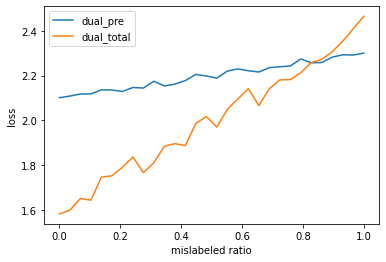

In [42]:
plt.plot(np.array(ratios), np.array(pre_train_loss_lst), label='dual_pre')
plt.plot(np.array(ratios), np.array(total_train_loss_lst), label='dual_total')
plt.xlabel("mislabeled ratio")
plt.ylabel("loss")
plt.legend()  # This will display the legend
plt.show()  # This will show the plot

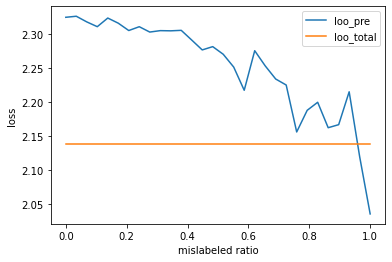

In [43]:
plt.plot(np.array(ratios), np.array(pre_loss_lst), label='loo_pre')
plt.plot(np.array(ratios), np.array(total_loss_lst), label='loo_total')
plt.xlabel("mislabeled ratio")
plt.ylabel("loss")
plt.legend()  # This will display the legend
plt.show()  # This will show the plot

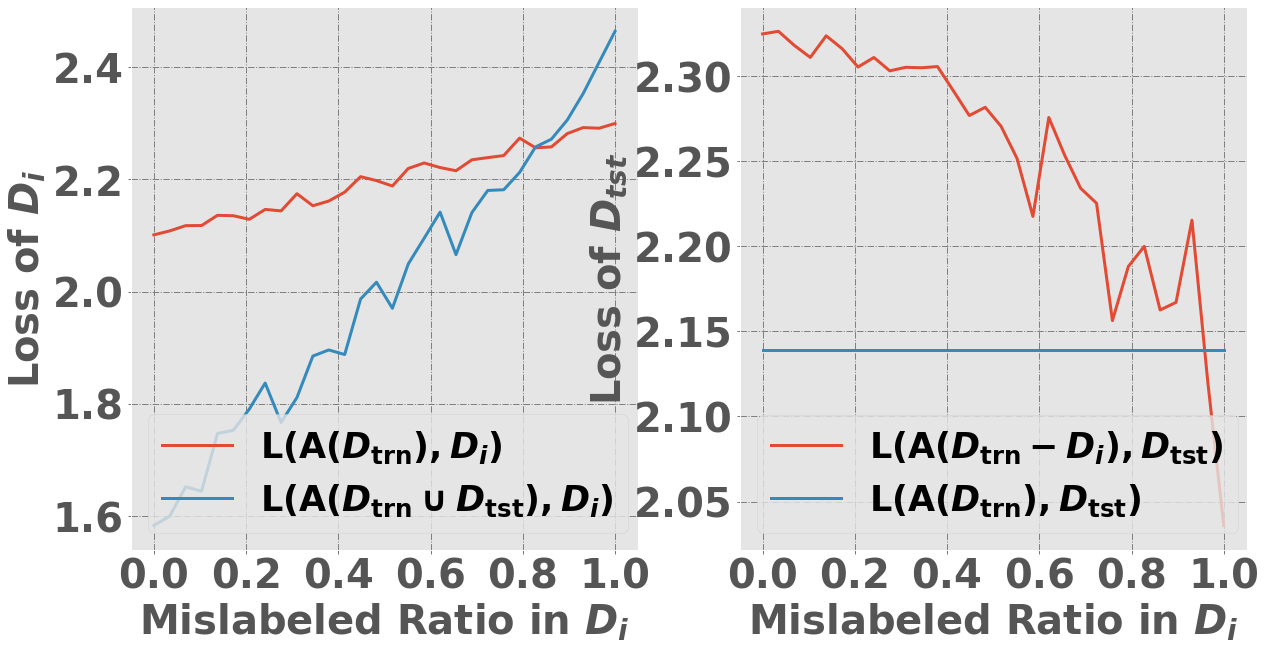

In [44]:
import numpy as np
import matplotlib as mpl
from scipy.stats import pearsonr

mpl.rcParams.update({'font.size': 40, 'font.weight': 'bold'})
plt.style.use('ggplot')

# Plotting
plt.figure(figsize=(20, 10))

# First subplot
plt.subplot(1, 2, 1)
plt.plot(np.array(ratios), np.array(pre_train_loss_lst), 
         label=r'$\mathrm{L}(\mathrm{A}(D_{\mathrm{trn}}),D_i)$', linewidth=3)
plt.plot(np.array(ratios), np.array(total_train_loss_lst), 
         label=r'$\mathrm{L}(\mathrm{A}(D_{\mathrm{trn}} \cup D_{\mathrm{tst}}),D_i)$', linewidth=3)
plt.xlabel('Mislabeled Ratio in ' + r'$D_{i}$', fontsize=40, fontweight='bold')
plt.ylabel('Loss of ' + r'$D_{i}$', fontsize=40, fontweight='bold')
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.grid(True, which='both', axis='both', color='grey', linestyle='-.', linewidth=1.0)
plt.legend(prop={'size': 35})

# Second subplot
plt.subplot(1, 2, 2)
plt.plot(np.array(ratios), np.array(pre_loss_lst), 
         label=r'$\mathrm{L}(\mathrm{A}(D_{\mathrm{trn}} - D_i),D_{\mathrm{tst}})$', linewidth=3)
plt.plot(np.array(ratios), np.array(total_loss_lst), 
         label=r'$\mathrm{L}(\mathrm{A}(D_{\mathrm{trn}}),D_{\mathrm{tst}})$', linewidth=3)
plt.xlabel('Mislabeled Ratio in ' + r'$D_{i}$', fontsize=40, fontweight='bold')
plt.ylabel('Loss of ' + r'$D_{tst}$', fontsize=40, fontweight='bold')
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.grid(True, which='both', axis='both', color='grey', linestyle='-.', linewidth=1.0)
plt.legend(prop={'size': 35})


# Display the combined plot
plt.show()

Correlation Coefficient: 0.8971151819558723


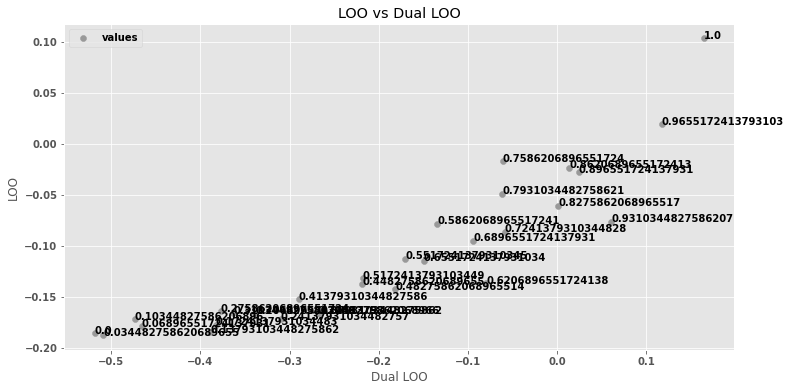

In [45]:
### Loo scores vs LOO scores
array1 = np.array(dual_loo_score)
array2 = np.array(loo_score)

# Calculate the correlation coefficient
correlation_coefficient, p = pearsonr(array1, array2)

print("Correlation Coefficient:", correlation_coefficient)

# Set the figure size
plt.figure(figsize=(12, 6))
plt.scatter(array1, array2, c='0.6', marker='o', label='values')

# Iterate over the points and annotate each point with its group size
for i, txt in enumerate(ratios):
    plt.annotate(txt, (array1[i], array2[i]))

# Add labels and titles
plt.xlabel('Dual LOO')
plt.ylabel('LOO')
plt.title('LOO vs Dual LOO')
plt.legend()
plt.show()

Correlation Coefficient for0.8971151819558723


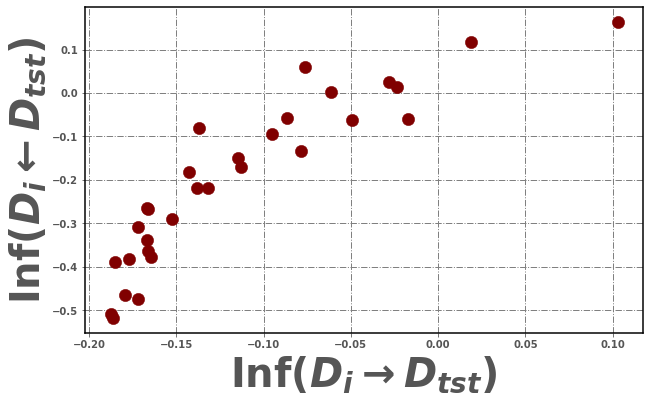

In [46]:
# Setting a larger default font size
import matplotlib as mpl
mpl.rcParams.update({'font.size': 40, 'font.weight': 'bold'})
plt.style.use('ggplot')
# Initialize a list to keep all the correlation coefficients
cor_score_lst = []

array1 = np.array(loo_score)
array2 = np.array(dual_loo_score)

# Calculate the correlation coefficient
correlation_coefficient, _ = pearsonr(loo_score, dual_loo_score)

# Print the correlation coefficient
print(f"Correlation Coefficient for{correlation_coefficient}")

# Scatter plot
plt.figure(figsize=(10, 6))
ax = plt.gca()  # Get the current Axes instance
ax.set_facecolor('none')  # Removing background color
#     ax.spines['top'].set_color('none')
#     ax.spines['right'].set_color('none')

# Making all spines visible to create a box
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1.5)

# Making grid lines visible
ax.grid(True, which='both', axis='both', color='grey', linestyle='-.', linewidth=1.0)

# Scatter plot adjustments
plt.scatter(array1, array2, c='maroon', marker='o', s=150, label='values')
# plt.title('CIFAR10 [Non-convex]', fontsize=40, fontweight='bold')    
# Updating axis labels with new notation
plt.xlabel(r'Inf($D_i \rightarrow D_{tst}$)', fontsize=40, fontweight='bold')
plt.ylabel(r'Inf($D_i \leftarrow D_{tst}$)', fontsize=40, fontweight='bold')
# Correcting the missing parenthesis
plt.show()  # Show the plot
    
plt.show()  # Show the plot

In [47]:
from scipy.stats import spearmanr
spearman_corr, _ = spearmanr(array1, array2)
print("Spearman Rank Correlation Coefficient:", spearman_corr)


Spearman Rank Correlation Coefficient: 0.9550611790878754


Pearson Correlation Coefficient: 0.8971
Spearman Correlation Coefficient: 0.9551


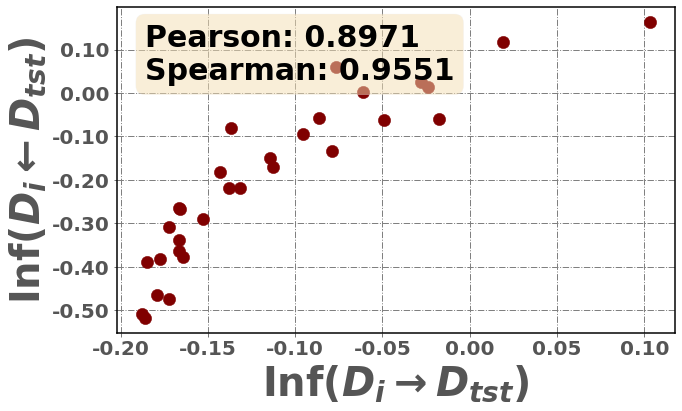

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import pearsonr, spearmanr
from matplotlib.ticker import FormatStrFormatter

# Setting a larger default font size
mpl.rcParams.update({'font.size': 40, 'font.weight': 'bold'})
plt.style.use('ggplot')

# Initialize arrays from loo_score and dual_loo_score
array1 = np.array(loo_score)
array2 = np.array(dual_loo_score)

# Calculate correlation coefficients
pearson_corr, _ = pearsonr(array1, array2)
spearman_corr, _ = spearmanr(array1, array2)

# Print the correlation coefficients
print(f"Pearson Correlation Coefficient: {pearson_corr:.4f}")
print(f"Spearman Correlation Coefficient: {spearman_corr:.4f}")

# Scatter plot setup
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.set_facecolor('none')

# Spine and grid setup
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1.5)
ax.grid(True, which='both', axis='both', color='grey', linestyle='-.', linewidth=1.0)

# Scatter plot
plt.scatter(array1, array2, c='maroon', marker='o', s=150)

# Axis labels
plt.xlabel(r'Inf($D_i \rightarrow D_{tst}$)', fontsize=40, fontweight='bold')
plt.ylabel(r'Inf($D_i \leftarrow D_{tst}$)', fontsize=40, fontweight='bold')

ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Display correlation coefficients in a box
info_text = f'Pearson: {pearson_corr:.4f}\nSpearman: {spearman_corr:.4f}'
plt.text(0.05, 0.95, info_text, transform=ax.transAxes, fontsize=30,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Adjusting tick label size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Show the plot
plt.show()

Pearson Correlation Coefficient: 0.8971
Spearman Correlation Coefficient: 0.9551


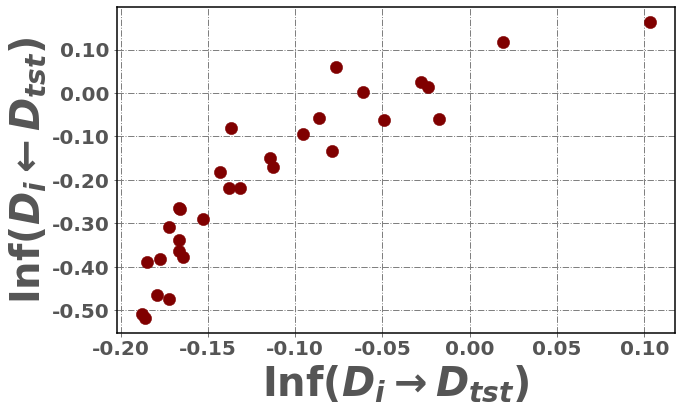

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import pearsonr, spearmanr
from matplotlib.ticker import FormatStrFormatter

# Setting a larger default font size
mpl.rcParams.update({'font.size': 40, 'font.weight': 'bold'})
plt.style.use('ggplot')

# Initialize arrays from loo_score and dual_loo_score
array1 = np.array(loo_score)
array2 = np.array(dual_loo_score)

# Calculate correlation coefficients
pearson_corr, _ = pearsonr(array1, array2)
spearman_corr, _ = spearmanr(array1, array2)

# Print the correlation coefficients
print(f"Pearson Correlation Coefficient: {pearson_corr:.4f}")
print(f"Spearman Correlation Coefficient: {spearman_corr:.4f}")

# Scatter plot setup
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.set_facecolor('none')

# Spine and grid setup
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1.5)
ax.grid(True, which='both', axis='both', color='grey', linestyle='-.', linewidth=1.0)

# Scatter plot
plt.scatter(array1, array2, c='maroon', marker='o', s=150)

# Axis labels
plt.xlabel(r'Inf($D_i \rightarrow D_{tst}$)', fontsize=40, fontweight='bold')
plt.ylabel(r'Inf($D_i \leftarrow D_{tst}$)', fontsize=40, fontweight='bold')

ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Adjusting tick label size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Show the plot
plt.show()